In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from multiprocessing import Pool

# # this time I will load the Dataset class from `./components/dataset.py`
# from components.dataset import Dataset

# path = "data"
# dataset = Dataset(path, "Valence")
# dataset = Dataset(path, "Arousal")

# data  = np.array(dataset[:]['data'])
# label = np.array(dataset[:]['label'])

# print("Data shape: " , data.shape)  #15360 = 32 participants * 40 trials * 12 segments, 32 EEG channels, 672 samples
# print("Label shape: ", label.shape)  #two classes of valence
# print(f"{sum(label==0)=} + {sum(label==1)=} = {sum(label==0)+sum(label==1)}")

# del(dataset)

# with open(f'cache/data_arousal.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(f'cache/label_arousal.pickle', 'wb') as handle:
#     pickle.dump(label, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
def load(path):
    with open(path, 'rb') as handle:
        data = pickle.load(handle)
    return data
def load_target(target):
    data = load(f"cache/data_{target}.pickle")
    label = load(f"cache/label_{target}.pickle")
    return data, label

# target = 'valence'
# target = 'arousal'
data,label_v = load_target('valence')
label_v = label_v.squeeze()
_, label_a = load_target('arousal')
label_a = label_a.squeeze()
print(data.shape, label_v.shape, label_a.shape)

(15360, 32, 672) (15360,) (15360,)


# Segment Compare

We are not sure that for each video, each 12 segment has a correlation of not.

In [3]:
def get_corr(p_id, data,label_v, label_a, video_indexs):
    # for video_index in range(40*32):
    print(f"p_id={p_id}: {video_indexs}")
    for video_index in video_indexs:
        participant_id = int(video_index / 40)
        start_index = video_index * 12
        stop_index = (video_index+1) * 12

        corr_video = []
        for a_index in range(start_index, stop_index):
            corr = []
            for b_index in range(start_index, stop_index):
                total_score = 0
                target_a = data[a_index]
                target_b = data[b_index]
                # calculate correlation from each channels
                for ch in range(32):
                    score = np.correlate(target_a[ch], target_b[ch])
                    total_score += score
                # scale down
                total_score = total_score/32
                corr.append(total_score)
            corr = np.hstack(corr)
            corr_video.append(corr)

        corr_video = np.vstack(corr_video)
        
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        corr_video = scaler.fit_transform(corr_video)
        # from sklearn.preprocessing import Normalizer
        # corr_video = Normalizer().fit_transform(corr_video)


        plt.rcParams["figure.figsize"] = (15,15)
        sn.heatmap(np.abs(corr_video), annot=True)
        title = f'subj{participant_id+1}-vid{(video_index%40) + 1}-val{int(label_v[video_index])}-aro{int(label_a[video_index])}'
        plt.title(title)
        plt.savefig(f'correlation_fig/by_video_norm/{title}.png')
        plt.close()
    return "done"

video_range = list(range(40*32))
try:
    t_out = 60000
    num_p = 1
    pool = Pool()
    p_list = []
    ans_list = []
    for p_id in range(num_p):
        p_list.append(pool.apply_async( get_corr, [p_id, data,label_v, label_a, video_range[p_id::num_p]] ))
    for i in range(num_p):
        ans_list.append( p_list[i].get(timeout=t_out) )
    # ans_list
finally:
    print("========= close ========")
    pool.close()
    pool.terminate()

p_id=0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

# Self compare

For each participant, there will be 40 session and 12 segment each.

For the sake of ease, we will compare the first segment of first session againt the rest. 

```
1. index[0] - index[0]
2. index[0] - index[1]
3. index[0] - index[2]
4. index[0] - index[3]
5. index[0] - index[4]
.
.
.
480. index[0] - index[479]
```

In [3]:
for participant in range(32):
    start_index = participant     * 40 * 12
    stop_index  = (participant+1) * 40 * 12

    corr_participant = []
    for index_a in range(start_index, stop_index):
        target_a = data[index_a]
        corr = []
        for index_b in range(start_index, stop_index):
            total_score = 0
            target_b = data[index_b]
            # calculate correlation from each channels
            for ch in range(32):
                score = np.correlate(target_a[ch], target_b[ch])
                total_score += score
            # scale down
            total_score = total_score/32
            corr.append(total_score)
        corr = np.hstack(corr)
        corr_participant.append(corr)

    corr_participant = np.vstack(corr_participant)
    print(f"saving {participant} {corr_participant.shape}")

    plt.rcParams["figure.figsize"] = (500,500)
    sn.heatmap(np.abs(corr_participant), annot=True)
    title = f'subj{participant+1}'
    plt.title(title)
    # plt.show()
    plt.savefig(f'correlation_fig/by_subject/{title}.png')
    plt.close()

saving 0 (480, 480)


In [ ]:
for participant in range(32):
    start_index = participant     * 40 * 12
    stop_index  = (participant+1) * 40 * 12

    corr_participant = []
    for index_a in range(start_index, stop_index):
        target_a = data[index_a]
        corr = []
        for index_b in range(start_index, stop_index):
            total_score = 0
            target_b = data[index_b]
            # calculate correlation from each channels
            for ch in range(32):
                score = np.correlate(target_a[ch], target_b[ch])
                total_score += score
            # scale down
            total_score = total_score/32
            corr.append(total_score)
        corr = np.hstack(corr)
        corr_participant.append(corr)

    corr_participant = np.vstack(corr_participant)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    corr_participant = scaler.fit_transform(corr_participant)
    print(f"saving {participant} {corr_participant.shape}")

    plt.rcParams["figure.figsize"] = (500,500)
    sn.heatmap(np.abs(corr_participant), annot=True)
    title = f'subj{participant+1}'
    plt.title(title)
    # plt.show()
    plt.savefig(f'correlation_fig/by_subject_std/{title}.png')
    plt.close()

In [35]:
same = []
diff = []
self_compare_same = []
self_compare_diff = []
for data_index in range(15360):
    total_score = 0
    for ch in range(32):
        score = np.correlate(data[0][ch], data[data_index][ch])
        total_score += score
    # print(f"{data_index}   total_score={total_score/32}, {label[data_index]}")
    if(data_index < 12*40):
        if(label[0] == label[data_index]):
            self_compare_same.append(total_score/32)
        else:
            self_compare_diff.append(total_score/32)
    else:
        if(label[0] == label[data_index]):
            same.append(total_score/32)
        else:
            diff.append(total_score/32)

228 252


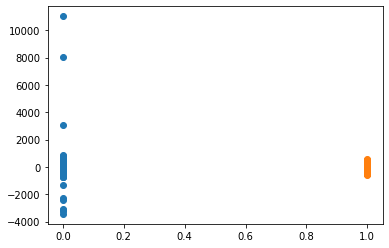

In [36]:
import matplotlib.pyplot as plt
print(len(self_compare_same), len(self_compare_diff))
plt.scatter([0] * len(self_compare_same), self_compare_same)
plt.scatter([1] * len(self_compare_diff), self_compare_diff)

8484 6864


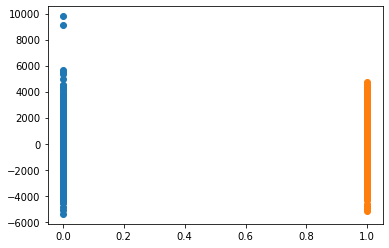

In [19]:
import matplotlib.pyplot as plt
print(len(same), len(diff))
plt.scatter([0] * len(same), same)
plt.scatter([1] * len(diff), diff)